<h1> Limpieza de los Datos </h1>

In [1]:
import pandas as pd

df = pd.read_excel('../data/raw/online_retail_II.xlsx')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
df = df.assign(
    Invoice=df["Invoice"].astype(str),
    StockCode=df["StockCode"].astype(str),
    Description=df["Description"].astype(str),
    Quantity=df["Quantity"].astype("int16"),
    Price=df["Price"].astype("float32"),
    CustomerID=df["Customer ID"].astype("Int32"),
    Country=df["Country"].astype(str)
)

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


In [2]:
df.to_parquet(
    "data/interim/online_retail_II.parquet",
    engine="pyarrow",
    compression="snappy"
)

ArrowInvalid: ("Could not convert 'C489449' with type str: tried to convert to int64", 'Conversion failed for column Invoice with type object')

In [4]:
variable = df[df['Invoice'] == 'C489449']
print(variable)

     Invoice StockCode                        Description  Quantity  \
178  C489449     22087           PAPER BUNTING WHITE LACE       -12   
179  C489449    85206A       CREAM FELT EASTER EGG BASKET        -6   
180  C489449     21895      POTTING SHED SOW 'N' GROW SET        -4   
181  C489449     21896                 POTTING SHED TWINE        -6   
182  C489449     22083         PAPER CHAIN KIT RETRO SPOT       -12   
183  C489449     21871                SAVE THE PLANET MUG       -12   
184  C489449     84946    ANTIQUE SILVER TEA GLASS ETCHED       -12   
185  C489449    84970S  HANGING HEART ZINC T-LIGHT HOLDER       -24   
186  C489449     22090          PAPER BUNTING RETRO SPOTS       -12   

            InvoiceDate  Price  Customer ID    Country  
178 2009-12-01 10:33:00   2.95      16321.0  Australia  
179 2009-12-01 10:33:00   1.65      16321.0  Australia  
180 2009-12-01 10:33:00   4.25      16321.0  Australia  
181 2009-12-01 10:33:00   2.10      16321.0  Australia  
182 

In [ ]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

Se eliminan valores nulos en las columnas 'Customer ID' y 'Description' ya que son los unicos campos que tienen valores nulos y son importantes para el analisis.

In [ ]:
df = df.dropna(subset=['Customer ID', 'Description'])
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [ ]:
df.duplicated().sum()

np.int64(6771)

Se eliminan los registros duplicados de todo el DataFrame.

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

Se verifica que las columnas 'Quantity' y 'Price' tengan valores mayores a 0, ya que son variables de conteo y precio por lo tanto no se necesitan valores negativos para el modelo.

In [ ]:
count_quantity = (df['Quantity'] > 0).sum()
count_quantity

np.int64(400947)

In [ ]:
count_price = (df['Price'] > 0).sum()
count_price

np.int64(410732)

Eliminacion de registros con valores negativos en las columnas anteriormente verificadas.

In [ ]:
df1 = df[(df['Quantity'] > 0) & (df['Price'] > 0)].sum()
df1

TypeError: 'DatetimeArray' with dtype datetime64[ns] does not support reduction 'sum'

En la primera linea de la siguiente celda, se convierte la Serie 'Customer ID' a tipo entero, ya que un identificador normalmente no tiene decimales.
En la segunda linea se crea una nueva columna llamada 'TotalPrice' que es el resultado de multiplicar las columnas 'Quantity' y 'Price', para obtener el precio total por transacción.

In [ ]:
df['Customer ID'] = df['Customer ID'].astype(int)
df['TotalPrice'] = df['Quantity'] * df['Price']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400916 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      400916 non-null  object        
 1   StockCode    400916 non-null  object        
 2   Description  400916 non-null  object        
 3   Quantity     400916 non-null  int64         
 4   InvoiceDate  400916 non-null  datetime64[ns]
 5   Price        400916 non-null  float64       
 6   Customer ID  400916 non-null  int64         
 7   Country      400916 non-null  object        
 8   TotalPrice   400916 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.6+ MB


Normalizacion de los nombres de las columnas del DataFrame, eliminando espacios en blanco, convirtiendo a minusculas y reemplazando caracteres especiales por sus equivalentes sin acentos.

In [ ]:
df.columns = (
    df.columns.str.strip()
            .str.lower()
            .str.replace('á', 'a')
            .str.replace('é', 'e')
            .str.replace('í', 'i')
            .str.replace('ó', 'o')
            .str.replace('ú', 'u')
            .str.replace('ñ', 'n')
            .str.replace(' ', '_')
)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400916 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoice      400916 non-null  object        
 1   stockcode    400916 non-null  object        
 2   description  400916 non-null  object        
 3   quantity     400916 non-null  int64         
 4   invoicedate  400916 non-null  datetime64[ns]
 5   price        400916 non-null  float64       
 6   customer_id  400916 non-null  int64         
 7   country      400916 non-null  object        
 8   totalprice   400916 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.6+ MB


Eliminacion de valores atipicos ya que solo representan el 6% de todos los datos y pueden afectar el rendimiento del modelo.

In [ ]:
Q1 = df['quantity'].quantile(0.25)
Q3 = df['quantity'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Identificar outliers
outliers = df[(df['quantity'] < lower_limit) | (df['quantity'] > upper_limit)]

In [ ]:
len(outliers) / len(df) * 100

6.558481078330623

In [ ]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Identificar outliers
outliers = df[(df['price'] < lower_limit) | (df['price'] > upper_limit)]

In [ ]:
len(outliers) / len(df) * 100

8.137116004350037

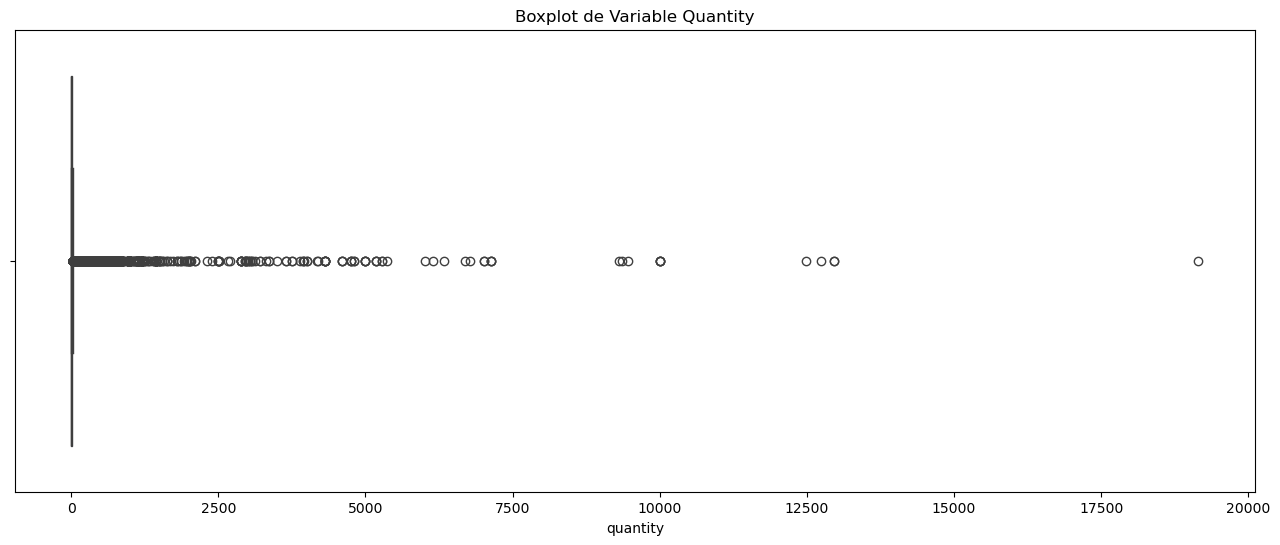

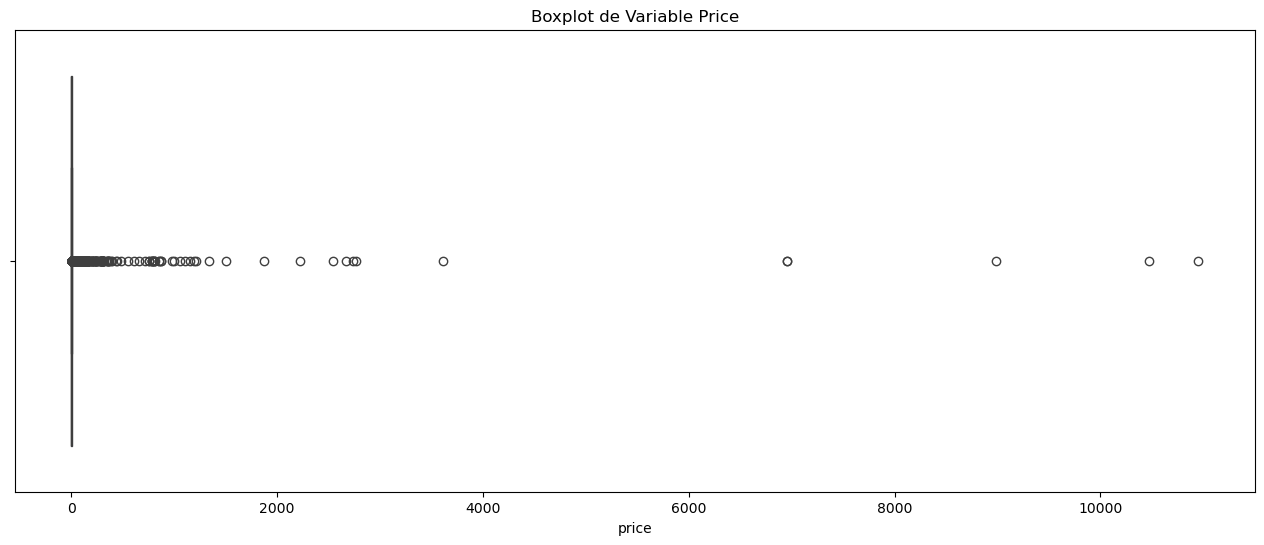

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
plt.title('Boxplot de Variable Quantity')
sns.boxplot(x=df['quantity'])
plt.show()

plt.figure(figsize=(16, 6))
plt.title('Boxplot de Variable Price')
sns.boxplot(x=df['price'])
plt.show()

Graficas de densidad para verificar la distribucion de las variables 'quantity' y 'price' despues de la eliminacion de los outliers.

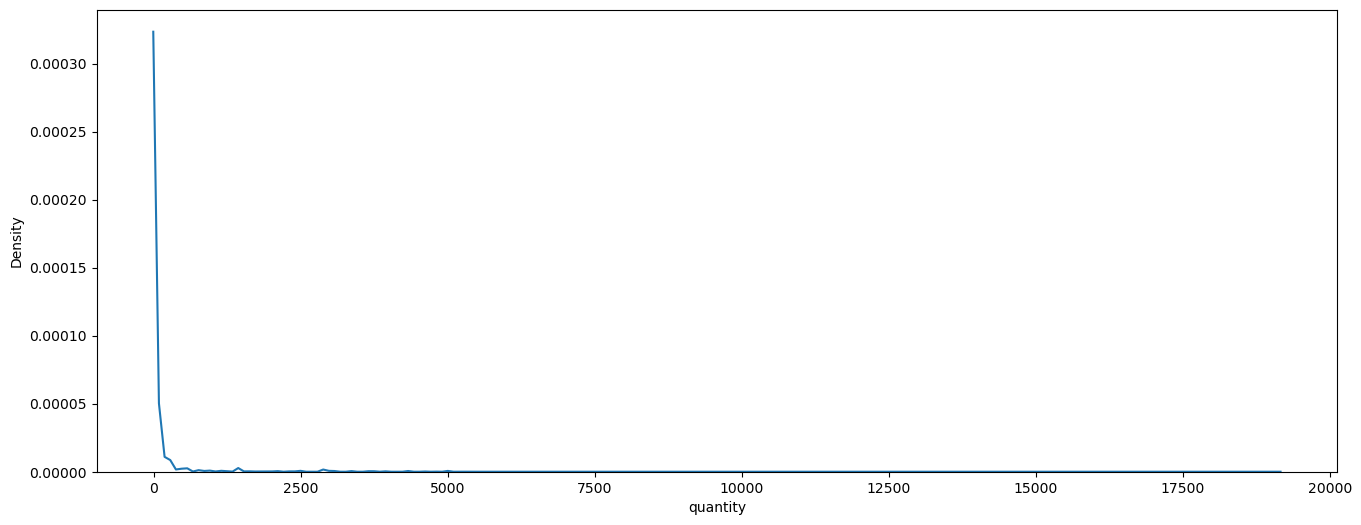

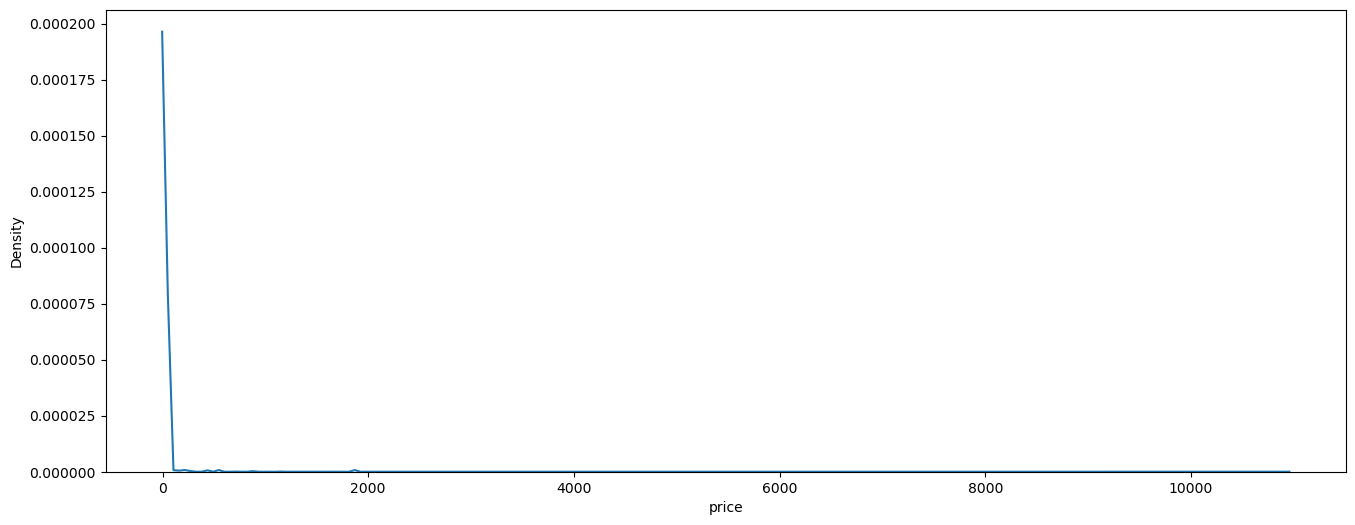

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
sns.kdeplot(df['quantity'], bw_adjust=0.5)
plt.show()

plt.figure(figsize=(16, 6))
sns.kdeplot(df['price'], bw_adjust=0.5)
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400916 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoice      400916 non-null  object        
 1   stockcode    400916 non-null  object        
 2   description  400916 non-null  object        
 3   quantity     400916 non-null  int64         
 4   invoicedate  400916 non-null  datetime64[ns]
 5   price        400916 non-null  float64       
 6   customer_id  400916 non-null  int64         
 7   country      400916 non-null  object        
 8   totalprice   400916 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.6+ MB


In [ ]:
df.describe()

,quantity,invoicedate,price,customer_id,totalprice
count,400916.000000,400916,400916.000000,400916.000000,400916.000000
mean,13.767418,2010-07-01 05:01:16.167027712,3.305826,15361.544074,21.945330
min,1.000000,2009-12-01 07:45:00,0.001000,12346.000000,0.001000
25%,2.000000,2010-03-26 13:28:00,1.250000,13985.000000,5.000000
50%,5.000000,2010-07-09 10:26:00,1.950000,15311.000000,12.500000
75%,12.000000,2010-10-14 13:58:45,3.750000,16805.000000,19.500000
max,19152.000000,2010-12-09 20:01:00,10953.500000,18287.000000,15818.400000
std,97.638385,NaN,35.047719,1680.635823,77.758075


In [ ]:
df.to_excel('../data/processed/online_retail_II_cleaned.xlsx', index=False)